In [0]:
import pandas as pd
import numpy as np
import keras as k
from keras.models import Sequential
from keras.layers import  Conv2D, MaxPool2D, Dropout, Dense, Flatten
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import SGD
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

import matplotlib.pyplot as plt
import tensorflow as tf

import os

In [2]:
zip_dir = k.utils.get_file('cats_and_dogs_filterted.zip', origin='https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip', extract=True)
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

68608000/68606236 [==============================] - 0s 0us/step


In [0]:
batch_size = 150
image_size = 250

train_image_generator = k.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                                 rotation_range = 30,
                                                                 width_shift_range = 0.2,
                                                                 height_shift_range = 0.2,
                                                                 shear_range = 0.2,
                                                                 horizontal_flip = True,
                                                                 fill_mode = 'nearest')

validation_image_generator = k.preprocessing.image.ImageDataGenerator(rescale = 1./255)

train_data_generator = train_image_generator.flow_from_directory(batch_size = batch_size,
                                                                      directory = train_dir,
                                                                      shuffle = True, 
                                                                      target_size = [image_size, image_size],
                                                                      class_mode = 'binary')

validation_data_generator = validation_image_generator.flow_from_directory(batch_size = batch_size,
                                                                      directory = validation_dir,
                                                                      shuffle = True, 
                                                                      target_size = [image_size, image_size],
                                                                      class_mode = 'binary')

In [0]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation= 'relu', input_shape = (150, 150, 3)))
model.add(MaxPool2D(2,2))
model.add(Conv2D(64, (3,3), activation= 'relu'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(128, (3,3), activation= 'relu'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(128, (3,3), activation= 'relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dense(2, activation = 'softmax'))

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()

In [0]:
epochs = 10
history = model.fit_generator(train_data_generator,
                              epochs = epochs,
                              steps_per_epoch= 20,
                              validation_data = validation_data_generator, validation_steps = 10)

In [5]:
#let's try fine tuning
base_model = VGG16(weights='imagenet', include_top=False, input_shape = (250,250,3))
for layer in base_model.layers:
  layer.trainable = False
flat1 = Flatten()(base_model.layers[-1].output)
output = Dense(2, activation = 'softmax')(flat1)

model = Model(inputs = base_model.inputs, outputs = output)
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

epochs = 6
history = model.fit_generator(train_data_generator,
                              epochs = epochs,
                              steps_per_epoch= 100,
                              validation_data = validation_data_generator, validation_steps = 50)

Epoch 1/6
100/100 [==============================] - 262s 3s/step - loss: 0.4796 - acc: 0.8062 - val_loss: 0.1972 - val_acc: 0.9288
Epoch 2/6
100/100 [==============================] - 237s 2s/step - loss: 0.2218 - acc: 0.9091 - val_loss: 0.1760 - val_acc: 0.9403
Epoch 3/6
100/100 [==============================] - 238s 2s/step - loss: 0.1962 - acc: 0.9186 - val_loss: 0.1923 - val_acc: 0.9262
Epoch 4/6
100/100 [==============================] - 236s 2s/step - loss: 0.1771 - acc: 0.9281 - val_loss: 0.1643 - val_acc: 0.9441
Epoch 5/6
100/100 [==============================] - 235s 2s/step - loss: 0.1601 - acc: 0.9375 - val_loss: 0.1573 - val_acc: 0.9476
Epoch 6/6
100/100 [==============================] - 232s 2s/step - loss: 0.1490 - acc: 0.9421 - val_loss: 0.2149 - val_acc: 0.9115


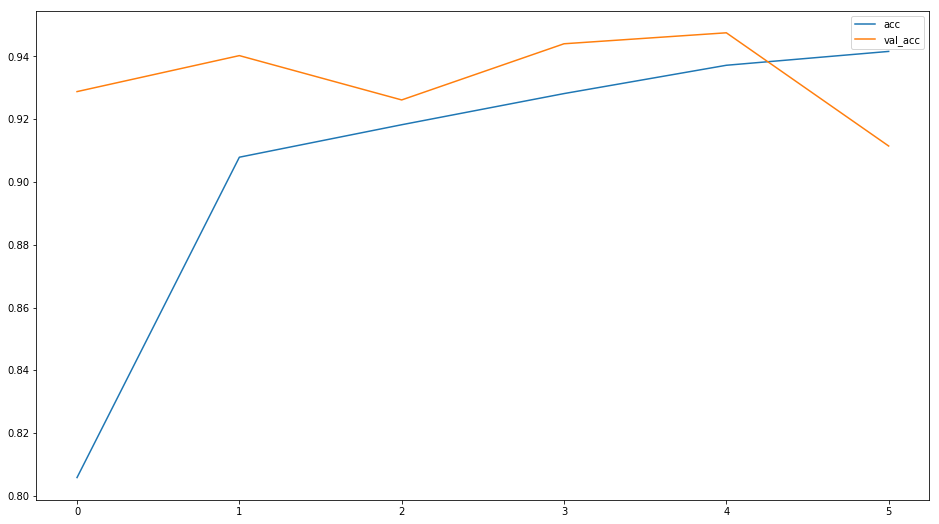

In [6]:
plt.figure(figsize=(16,9))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])

In [0]:
#save model with weights
model.save('CatDog.h5')

cat:1.0 
dog:0.0


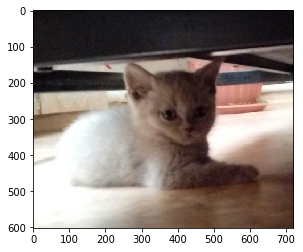

In [10]:
def load_image(path, size = [250,250]):
  img = load_img(path, target_size = size)
  return img_to_array(img).reshape(1,size[0],size[1],3)

catdog_classifier = load_model('CatDog.h5')
answer = catdog_classifier.predict(load_image('example.jpg'))
plt.imshow(load_img('example.jpg', [250,250]))
print(f"cat:{answer[0][0]} \ndog:{answer[0][1]}")